In [2]:
import numpy as np
import pandas as pd
import math
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
from fed_common.config_functions import get_datasets
from datasets.fashion_mnist.utils.mnist_reader import load_mnist

## Load original Fashion MNIST dataset

In [6]:
ls ..

 conda-env.txt      'paper results'/    run_fedTrees.py
 datasets/           privkeys/          runServer.sh*
'dataset scripts'/   README.html        run.sh*
 default.sqlite      README.md          src/
 fed_common/         requirements.txt   stopServer.sh*
 init.sh             run_fedLin.py      stop.sh*
 nginx/              run_fedNN.py       vantage6_config_files/


In [7]:
X_train, y_train_tmp = load_mnist('../datasets/fashion_mnist/data/fashion', kind='train')
X_test, y_test_tmp = load_mnist('../datasets/fashion_mnist/data/fashion', kind='t10k')

y_train = np.empty((60000, 1))
y_test = np.empty((10000, 1))

y_train[:,0] = y_train_tmp
y_test[:,0] = y_test_tmp

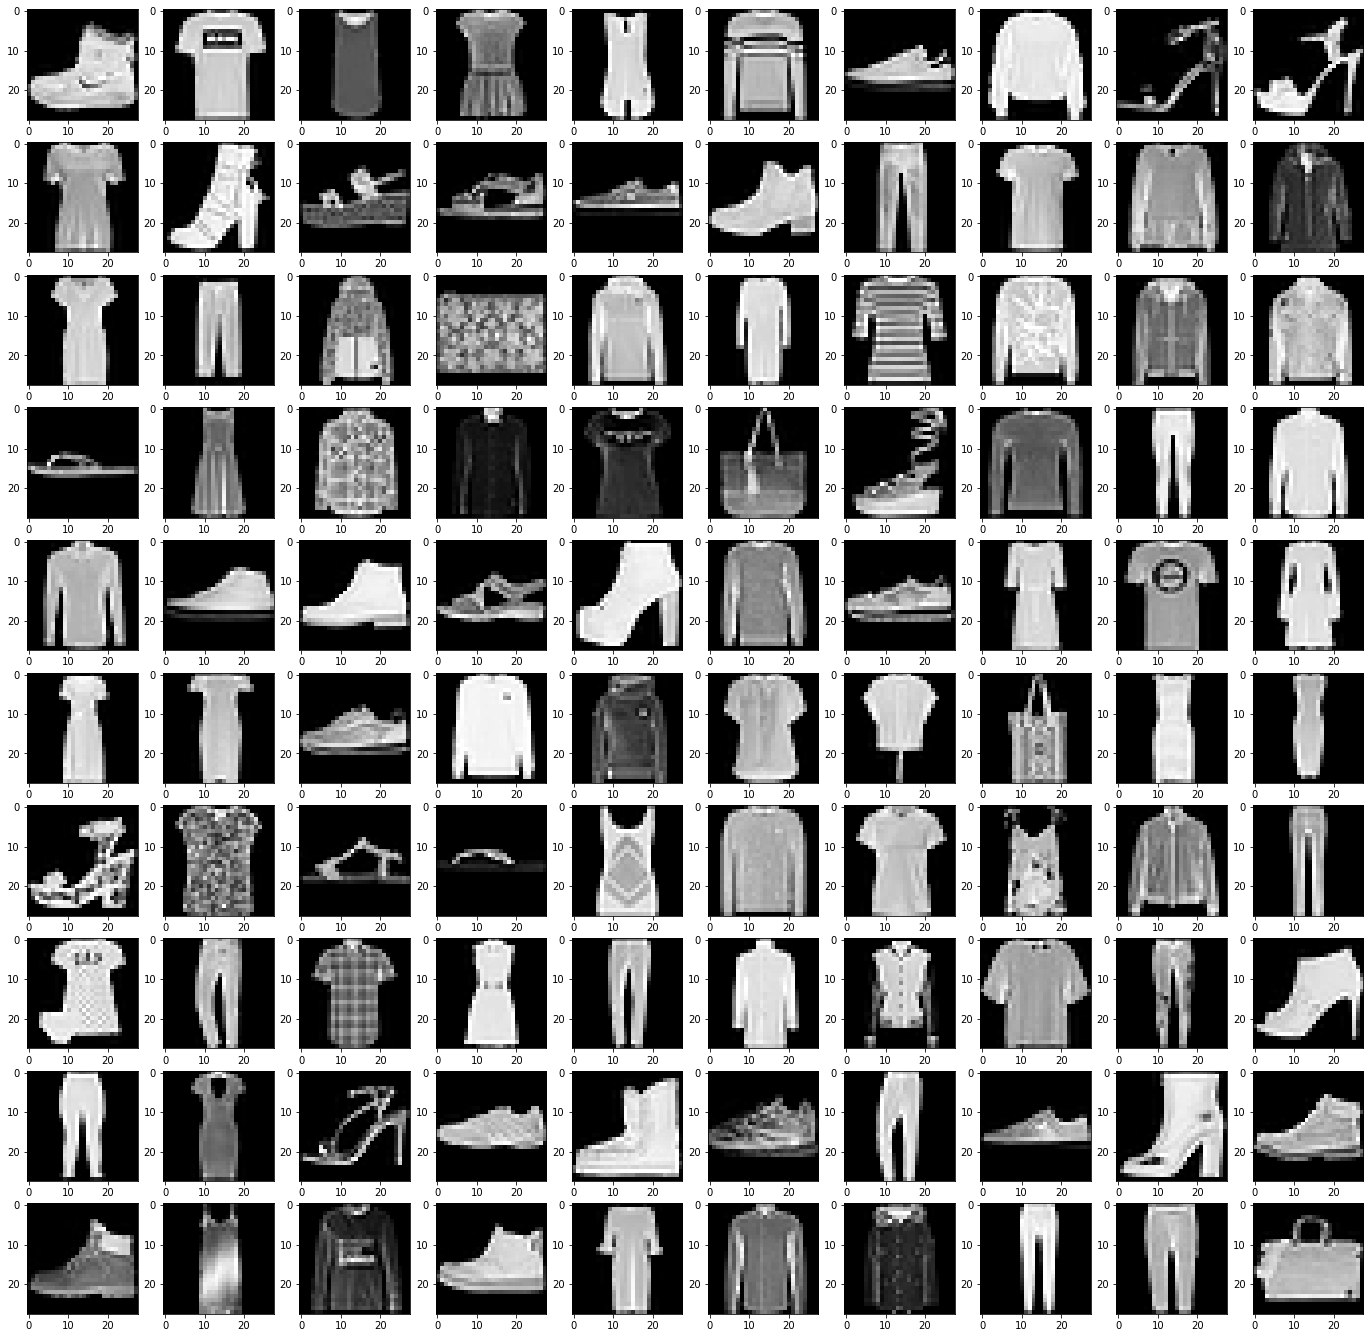

In [8]:
#show some samples
plt.rcParams['figure.figsize'] = [24, 24]
x_image = X_train.reshape((60000,28,28))
fig, axs = plt.subplots(10,10)
for i in range(100):
    axs[math.floor(i/10), i%10].imshow(x_image[i,:,:], cmap="gray")


## processing and dividing into 10 equal parts

In [10]:
#normalize
X_train_norm = X_train / 255
X_test_norm = X_test/255

dims = ['pixel' + str(i) for i in range(784)] 
df1 = pd.DataFrame(X_train_norm, columns = dims)
df1['label'] = y_train
df1['test/train'] = "train"
#df1.head()

df2 = pd.DataFrame(X_test_norm, columns = dims)
df2['label'] = y_test
df2['test/train'] = "test"


df = pd.concat([df1, df2], axis = 0, ignore_index=False)

df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label,test/train
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,9.0,train
1,0.0,0.0,0.0,0.0,0.0,0.003922,0.0,0.0,0.000000,0.000000,...,0.509804,0.298039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.086275,...,0.003922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.129412,0.376471,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.0,train
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [18]:
clients = []

num_clients = 10

#shuffle the test/training sample through each other
df = df.sample(frac=1).reset_index(drop=True)


for i in range(num_clients):
    client = df.iloc[i*7000:(i+1)*7000]
    clients.append(client)
    #print(i*100, (i+1)* 100 - 1)


#separate into 10 equal pieces
for i , client in enumerate(clients):
    #print(math.floor(i/5), i%5)
    num_test = client.loc[client['test/train'] == 'train'].count()[0]
    print(num_test)
    #plt.bar(x, num_test)
    #axs_sc[math.floor(i/5),i%5].bar(x, num_test)



6001
6016
5974
5994
6002
6012
6019
5985
5975
6022


In [ ]:
# save to csv    
for i, client in enumerate(clients):
    name = 'fashion_MNIST_dataset_client' + str(i) + '.csv'
    client.to_csv(name, index=False)

## Create aggresive CI dataset

In [12]:
rng = np.random.default_rng()


# sort the dataframe by label
df = df.sort_values('label')
train_data = df.loc[df["test/train"] == "train"]
test_data = df.loc[df["test/train"] == "test"]

train_data = train_data.sort_values('label', ignore_index = True)
test_data = test_data.sort_values('label', ignore_index = True)

#print(train_data['label'])

num_clients = 10
part_num = 100
part_size = math.floor(train_data.shape[0] / part_num)
test_part_size = math.floor(test_data.shape[0] / part_num)
shards_per_client = math.floor(part_num/num_clients)
ci_clients = []

part_inds = np.arange(part_num)
rng.shuffle(part_inds)
#divide into 200 parts (only training data)

for i in range (num_clients):
    for shard_num in range(shards_per_client):
        shard_i = part_inds[shard_num + shards_per_client * i]
        #print(shard_i)
        shard = train_data.iloc[shard_i * part_size :shard_i* part_size + part_size]
        #print(shard['label'])
        #print(shard['label'].unique())
        #print(shard['label'].unique().shape)
        test_shard = test_data.iloc[shard_i * test_part_size :shard_i* test_part_size + test_part_size]
        #print(test_shard['label'].unique())
        full_shard = pd.concat([shard,test_shard])
        #full_shard = shard
        if shard_num == 0:
            client = full_shard
        else:
            client = pd.concat([client,full_shard])
    ci_clients.append(client)
    print(client['label'].unique().shape)
#print(part_inds)


(7,)
(8,)
(6,)
(5,)
(4,)
(7,)
(7,)
(8,)
(8,)
(5,)


In [ ]:
# to csv
for i, client in enumerate(ci_clients):
    client.to_csv("fashion_MNIST_superCI_client" + str(i) + ".csv", index=False)

## Visuals for both datasets

Text(0, 0.5, 'sample size')

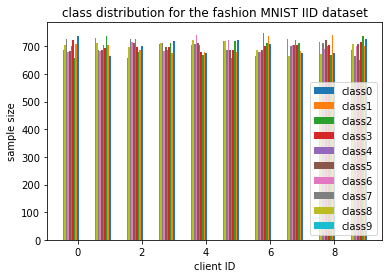

In [19]:
plt.figure(figsize=[6,4])
#plt.rcParams['figure.figsize'] = [6, 4]

for i, client in enumerate(clients):
    #client = pd.read_csv(datasets_paths[0])
    for j in range(10):
        samples = client.loc[client['label'] == j].shape[0]
        plt.bar(i - j * 0.05, samples, width = 0.05)

plt.legend(['class' + str(i) for i in range(10)], loc="lower right")
plt.title("class distribution for the fashion MNIST IID dataset")
plt.xlabel("client ID")
plt.ylabel("sample size")

Text(0, 0.5, 'sample size')

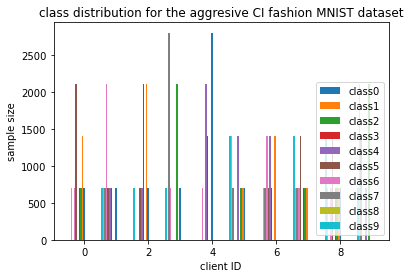

In [17]:
plt.figure(figsize=[6,4])
#plt.rcParams['figure.figsize'] = [6, 4]


for i, client in enumerate(ci_clients):
    #client = pd.read_csv(datasets_paths[0])
    for j in range(10):
        samples = client.loc[client['label'] == j].shape[0]
        plt.bar(i - j * 0.05, samples, width = 0.05)

plt.legend(['class' + str(i) for i in range(10)], loc="lower right")
plt.title("class distribution for the aggresive CI fashion MNIST dataset")
plt.xlabel("client ID")
plt.ylabel("sample size")